In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import glob
from astropy.table import Table
import sys
sys.path.append('..')
from util.helper import *
from util.sdtpy import *
import inspect
import matplotlib.pyplot as plt
from astropy.time import Time

In [2]:
def tablize_sedinfo(path_sedinfo, models):
	infotbl = Table()
	infotbl['model'] = models
	
	with open(path_sedinfo, 'r') as f:
		for line in f:
			#	Find parameter row
			if line.startswith('PARNAMES: '):
				# print(line)
				headers = line.split()[1:]
				break
		#	Generate empty columns
		for header in headers:
			infotbl[header] = 0.0

		for ll, line in enumerate(f):
			if ll < len(infotbl):
				#	Values
				if line.startswith('SED:'):
					vals = line.split()[2:]
					for hh, header in enumerate(headers):
						infotbl[header][ll] = float(vals[hh])

	return infotbl


In [36]:
snrcut = 3
source = 'MOSFiT'
fittype = 'SNIax'
verbose = True

In [4]:
models = sorted(glob.glob(f'../model/PLAsTiCC/{fittype}/SIMSED.{fittype}/*.fits'))
print(f"{len(models)} models found") 

1001 models found


In [5]:
path_sedinfo = f'../model/PLAsTiCC/{fittype}/SIMSED.{fittype}/SED.INFO'
infotbl = tablize_sedinfo(path_sedinfo, models)

In [71]:
ii = 10
model = models[ii]
_mdtbl = Table.read(model)

indx = np.where(
    (_mdtbl['col1'] <= 30) &
    (_mdtbl['col2'] >= 2000) &
    (_mdtbl['col2'] <= 10000)
)

mdtbl = _mdtbl[indx]
phasearr = np.unique(mdtbl['col1'])
lamarr = np.unique(mdtbl['col2'])
number_of_unique_phase, number_of_unique_wavelength = len(phasearr), len(lamarr)
flux2darr = mdtbl['col3'].reshape(number_of_unique_phase, number_of_unique_wavelength)

print(f"Table length: {len(_mdtbl)} --> {len(mdtbl)}")

Table length: 112800 --> 22400


In [7]:
param_keys = infotbl.keys()[2:]
param_keys

['M_V', 't_rise', 'dm15B', 'dm15R']

In [9]:
# 데이터 변환
X, y = prepare_rf_train_data(infotbl, param_keys, phasearr, number_of_unique_phase, number_of_unique_wavelength, phase_upper=30., lam_lower=2000., lam_upper=10000.)
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Random Forest 모델 생성 및 훈련
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [11]:
# 테스트 데이터에 대한 예측 수행
y_pred = rf.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 평균 제곱 오차 (MSE) 계산
mse = mean_squared_error(y_test, y_pred)
print("평균 제곱 오차 (MSE):", mse)

# 평균 절대 오차 (MAE) 계산
mae = mean_absolute_error(y_test, y_pred)
print("평균 절대 오차 (MAE):", mae)

# 결정 계수 (R-squared) 계산
r2 = r2_score(y_test, y_pred)
print("결정 계수 (R-squared):", r2)

평균 제곱 오차 (MSE): 8.334620878363752e-07
평균 절대 오차 (MAE): 0.00022251594258380382
결정 계수 (R-squared): 0.9972030201323474


# Fitting the model

## Input data

In [81]:
register_custom_filters_on_speclite('../util')

Use `med25nm`, `med50nm`, `broad` as `group_name`


In [82]:
intype = 'kn'
indist = 40
inexptime = 180
# group = 'broad_ugriz'
group = input("""Choose the filterset (med25nm, broad_griz, broad_ugriz):""")
if group == 'med25nm':
	filterset_group = filterlist_med25nm
elif group == 'broad_griz':
	filterset_group = filterlist_griz
elif group == 'broad_ugriz':
	filterset_group = filterlist_ugriz
filterset = [f"{group}-{filte}" for filte, _, group in filterset_group]
bands = speclite.filters.load_filters(*filterset)

if 'med' in bands.names[0]:
	#    Medium-band
	bandwidth = 250 # [AA]
	lammin = 3000
	lammax = 10000
else:
	#	Broad-band
	bandwidth = 1000 # [AA]
	lammin = 2000
	lammax = 12000

lamstep = bandwidth/10
# lamarr = np.arange(lammin, lammax+lamstep, lamstep)
# _lamarr = np.arange(lammin, lammax+lamstep, 10)

print(f"lam: {lammin:.3f} - {lammax:.3f} AA")
print(f"lamstep: {lamstep:g} AA")
print(f"n_lam: {len(lamarr)}")

lam: 3000.000 - 10000.000 AA
lamstep: 25 AA
n_lam: 400


In [83]:
if group == 'med25nm':
	#	Medium-band
	path_input = f'../input/{intype}/{indist:0>3}Mpc/{inexptime:0>3}s/{group}'
else:
	#	Broad-band
	path_input = f'../input/{intype}/{indist:0>3}Mpc/{inexptime:0>3}s/broad'
path_output = f'../fit_result/{intype}2{fittype}/{indist:0>3}Mpc/{inexptime:0>3}s/{group}'
if not os.path.exists(path_output):
	os.makedirs(path_output)
outfits = f"{path_output}/fit_result.fits"

In [84]:
intablelist = sorted(glob.glob(f"{path_input}/obs.*.fits"))
print(f"{len(intablelist)} input tables found")

3600 input tables found


In [110]:
outbl = Table()
#	Input data
outbl['input_table'] = [os.path.basename(intable) for intable in intablelist]
#	Detection / Fit
outbl['ndet'] = 0
outbl['det_filters'] = " "*200
outbl['det'] = False
outbl['fit'] = False
#	Fitted Parameters
outbl['z'] = 0.
outbl['t'] = 0.
for key in param_keys:
	outbl[key] = 0.
#	Error
outbl['zerr'] = 0.
outbl['terr'] = 0.
for key in param_keys:
	outbl[f"{key}err"] = 0.

#	Fit Results
outbl['free_params'] = 0
outbl['dof'] = 0
outbl['chisq'] = 0.
outbl['chisqdof'] = 0.
outbl['bic'] = 0.
#	Meta
outbl.meta['fittype'] = fittype
outbl.meta['source'] = source
outbl.meta['intype'] = intype
outbl.meta['indist[Mpc]'] = indist
outbl.meta['inexptime[s]'] = inexptime
outbl.meta['group'] = group
outbl.meta['date'] = Time.now().isot

In [111]:
#	Temp Table
_mdtbl = Table.read(intablelist[0])
for key, val in _mdtbl.meta.items():
	if key in ['MD', 'VD', 'MW', 'VW', 'ANG', 'PHASE', 'REDSHIFT',]:
		if type(val) is str:
			outbl[key] = ' '*10
		elif type(val) is float:
			outbl[key] = 0.0
		elif type(val) is int:
			outbl[key] = 0

In [85]:
def func(x, z, t, M_V, t_rise, dm15B, dm15R):

	new_data = np.array(
		[[M_V, t_rise, dm15B, dm15R, t]]
		)

	#	Spectrum : wavelength & flux
	flam = rf.predict(new_data)[0]

	#	Redshifted
	(zspappflam, zsplam) = apply_redshift_on_spectrum(flam*flamunit, lamarr*lamunit, z, z0=0)
	mags = bands.get_ab_magnitudes(*bands.pad_spectrum(zspappflam, zsplam))

	spmag = np.array([mags[key][0] for key in mags.keys()])
	spfnu = (spmag*u.ABmag).to(u.uJy).value

	return spfnu

In [86]:
ii = 10
intable = intablelist[ii]
st = time.time()

In [87]:
print(f"{os.path.basename(intable)} ({inexptime}s) --> {fittype}")
intbl = Table.read(intable)

obs.000010.fits (180s) --> SNIax


In [88]:
indx_det = np.where(intbl['snr']>snrcut)
filterlist_det = list(intbl['filter'][indx_det])
filterlist_str = ",".join(filterlist_det)

In [89]:
filterset = [f"{group}-{filte}" for filte, _, group in filterset_group if filte in filterlist_det]
bands = speclite.filters.load_filters(*filterset)

In [90]:
# %%
ndet = len(filterset)
detection = np.any(intbl['snr'] > 5)
if verbose:
	print(f"number of detections: {ndet}")
	print(f"detection: {detection}")

number of detections: 18
detection: True


In [91]:
xdata = intbl['fnuobs'].data[indx_det]
ydata = xdata
sigma = intbl['fnuerr'].data[indx_det]

- x, z, t, M_V, t_rise, dm15B, dm15R

In [102]:
p0 = (
	0.01, 0, np.mean(infotbl['M_V']), np.mean(infotbl['t_rise']), np.mean(infotbl['dm15B']), np.mean(infotbl['dm15B']),
)

bounds = (
	(0.0, -np.inf, np.min(infotbl['M_V']), np.min(infotbl['t_rise']), np.min(infotbl['dm15B']), np.min(infotbl['dm15R'])),
	(1.0, 30,      np.max(infotbl['M_V']), np.max(infotbl['t_rise']), np.max(infotbl['dm15B']), np.max(infotbl['dm15R'])),
)

n_free_param = len(inspect.signature(func).parameters)-1

In [103]:
fit = False
try:
	popt, pcov = curve_fit(
		func,
		xdata=xdata,
		ydata=ydata,
		sigma=sigma,
		# p0=p0,
		absolute_sigma=True,
		check_finite=True,
		bounds=bounds,
		method='trf',
		# max_nfev=1e4,
	)
	fit = True
except Exception as e:
	# print(e)
	outlog = f"{path_output}/{os.path.basename(intable).replace('obs', 'fit').replace('fits', 'log')}"
	f = open(outlog, 'w')
	f.write(str(e))
	f.close()
	fit = False


In [105]:
if fit:
	#	Fitting result
	r = ydata.data - func(xdata, *popt)
	n_free_param = len(inspect.signature(func).parameters)-1
	dof = ndet - n_free_param
	chisq_i = (r / sigma) ** 2
	chisq = np.sum(chisq_i)
	chisqdof = chisq/dof
	bic = chisq + n_free_param*np.log(ndet)
	perr = np.sqrt(np.diag(pcov))

	# %%
	z = popt[0]
	t = popt[1]
	M_V = popt[2]
	t_rise = popt[3]
	dm15B = popt[4]
	dm15R = popt[5]
	if verbose:
		print(f"z={z:.3}")
		print(f"t={t:.3}")
		print(f"M_V={M_V:.3}")
		print(f"t_rise={t_rise:.3}")
		print(f"dm15B={dm15B:.3}")
		print(f"dm15R={dm15R:.3}")

	# %%
	outpng = f"{path_output}/{os.path.basename(intable).replace('obs', 'fit').replace('fits', 'png')}"


z=0.0157
t=29.0
M_V=-15.7
t_rise=14.8
dm15B=1.77
dm15R=0.724


In [112]:
#	Detection / Fit
outbl['ndet'][ii] = ndet
outbl['det_filters'][ii] = filterlist_str
outbl['det'][ii] = detection
outbl['fit'][ii] = fit
#	Fitted Parameters
outbl['z'][ii] = z
outbl['t'][ii] = t
outbl['M_V'][ii] = M_V
outbl['t_rise'][ii] = t_rise
outbl['dm15B'][ii] = dm15B
outbl['dm15R'][ii] = dm15R

#	Error
outbl['zerr'][ii] = perr[0]
outbl['terr'][ii] = perr[1]
outbl['M_Verr'][ii] = perr[2]
outbl['t_riseerr'][ii] = perr[3]
outbl['dm15Berr'][ii] = perr[4]
outbl['dm15Rerr'][ii] = perr[5]

#	Fit Results
outbl['free_params'][ii] = n_free_param
outbl['dof'][ii] = dof
outbl['chisq'][ii] = chisq
outbl['chisqdof'][ii] = chisqdof
outbl['bic'][ii] = bic

In [106]:
new_data = np.array(
	[[M_V, t_rise, dm15B, dm15R, t]]
	)

#	Spectrum : wavelength & flux
flam = rf.predict(new_data)[0]

In [107]:
(zspappflam, zsplam) = apply_redshift_on_spectrum(flam*flamunit, lamarr*lamunit, z, z0=0)
mags = bands.get_ab_magnitudes(zspappflam, zsplam)

spmag = np.array([mags[key][0] for key in mags.keys()])
spfnu = (spmag*u.ABmag).to(u.uJy).value

# %%
fnuarr = convert_flam2fnu(zspappflam, zsplam).to(u.uJy)

In [108]:
label = f"""n_det={ndet}, rchisq={chisqdof:.3f}, bic={bic:.3f}
z ={z:.3f}, t ={t:.3f}
M_V={M_V:.3f}, t_rise={t_rise:.3f}, dm15B={dm15B:.3f}, dm15R={dm15B:.3f}"""

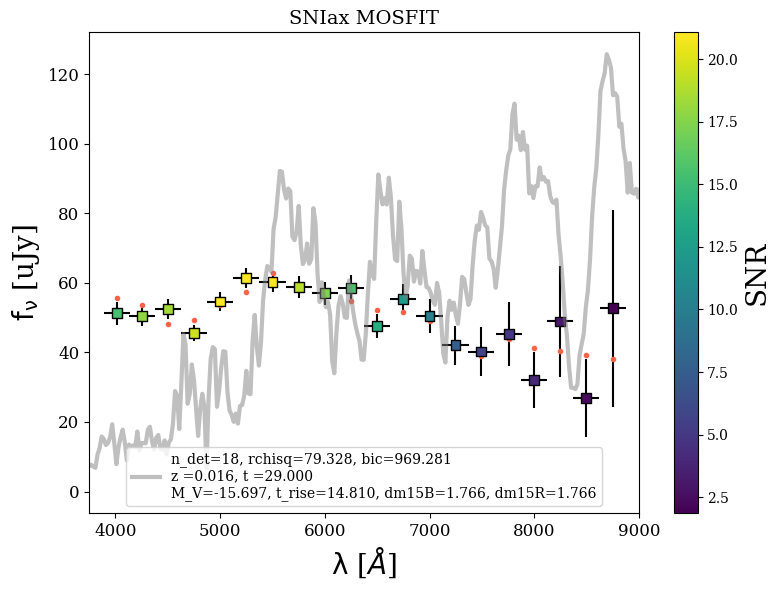

In [109]:
plt.close('all')
plt.figure(figsize=(8, 6))
plt.plot(lamarr, fnuarr, c='grey', lw=3, alpha=0.5, label=label)
yl, yu = plt.ylim()
# plt.scatter(bands.effective_wavelengths, xdata, c=intbl['snr'], marker='s', s=50, ec='k')
plt.scatter(intbl['lam'], intbl['fnuobs'], c=intbl['snr'], marker='s', s=50, ec='k')
if 'med' in group:
	plt.errorbar(intbl['lam'], intbl['fnuobs'], xerr=bandwidth/2, yerr=intbl['fnuerr'], c='k', ls='none', zorder=0)
elif 'broad' in group:
	# plt.errorbar(intbl['lam'], intbl['fnuobs'], xerr=bandwidtharr_broad[indx_det]/2, yerr=intbl['fnuerr'], c='k', ls='none', zorder=0)					
	plt.errorbar(intbl['lam'], intbl['fnuobs'], xerr=bandwidtharr_broad/2, yerr=intbl['fnuerr'], c='k', ls='none', zorder=0)					
cbar = plt.colorbar()
cbar.set_label("SNR")
# plt.plot(bands.effective_wavelengths, func(xdata, *popt), '.', c='tomato')
plt.plot(intbl['lam'], intbl['fnu'], c='tomato', marker='.', ls='none', zorder=0)
plt.title(f"{fittype} {source.upper()}")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
if 'med' in group:
	xl = 3750
	xr = 9000
else:
	xl = 3000
	xr = 10000
plt.xlim([xl, xr])
plt.ylim([yl, yu])
plt.xlabel(r"$\rm \lambda$ [$\AA$]")
plt.ylabel(r"$\rm f_\nu$ [uJy]")
plt.legend(loc='lower center')
plt.tight_layout()
plt.savefig(outpng, dpi=100)

In [ ]:
ed = time.time()
delt = ed-st
outbl.meta['time[s]'] = delt
outbl.write(outfits, overwrite=True)
print(f"Done ({delt:.3}s)")